<a href="https://colab.research.google.com/github/Existanze54/sirius-machine-learning-2025/blob/main/Lections/L06_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Основные алгоритмы машинного обучения

### Лекция 6: Кластеризация.

#### K-Means. DBSCAN. Affinity propagation. Иерархическая кластеризация. Кластеризация биологических объектов.

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## Задача кластеризации

В **unsupervised learning** ставится задача о поиске структуры в данных.

В этом случае задача формулируется следующим образом:

пусть $X$ - признаковое пространство объектов, дана $\{x_1, \ldots, x_l\}\subset X$ - выборка и определена функция расстояний между объектами $\rho: X\times X\rightarrow[0,\infty)$.

Требуется определить:

$Y$ - множество кластеров с помощью $a: X\rightarrow Y$ - алгоритма кластеризации. В результате работы $a$ должно выполняться следующее:   
* объекты внутри одного кластера похожи;   
* объекты разных кластеров различны.

Решение задачи кластеризации в классической постановке неоднозначно. Мы не знаем:
* Приемлемой для нас степени сходства между объектами,
* Количества определяемых кластеров,
* Насколько непохожие объекты могут входить в один кластер...
* и т.д.

### Теорема Клейнберга

Сравнительно недавно (по меркам математики) была опубликована статья, в которой вводятся три достаточно простых свойства, которыми (как мы ожидаем) должен обладать "правильный" алгоритм кластеризации.

Автор доказывает теорему о том, что алгоритма, который обладает одновременно тремя этими свойствами, не существует.

[Статья](https://dl.acm.org/doi/10.5555/2968618.2968676), [PDF](https://www.cs.cornell.edu/home/kleinber/nips15.pdf).

**Масштабная инвариантность**:

Если для любых функции расстояния $\rho$ и константы $a$ результат кластеризации для расстояний между объектами $D_X$ совпадает с результатов кластеризации для расстояний $a * D_X$, то такой алгоритм кластеризации называется масштабно-инвариантным.

<img src="https://data.bioml.ru/htdocs/courses/bioml/classic_ml/unsupervised/clustering/img/clustering_scale_invariance.png" width="800"/>

**Согласованность**:

Алгоритм кластеризации называется согласованным, если результат кластеризации не меняется при любом уменьшении расстояния между объектами из одного кластера или увеличении расстояния между объектами из разных кластеров.

<img src="https://data.bioml.ru/htdocs/courses/bioml/classic_ml/unsupervised/clustering/img/clustering_consistency.png" width="800"/>

**Полнота**:

Алгоритм кластеризации обладает полнотой, если для любого заданного разбиения объектов на кластеры можно подобрать такие параметры алгоритма, что он разобьет объекты тем же образом.

**Как-то не очень воодушевляет** :^)

### Наивный алгоритм кластеризации

Представим, что мы хотим вручную реализовать алгоритм кластеризации для самой простой задачи: разбиение на два кластера. Как бы мы это сделали?

Один из способов - осуществлять разделение по уже имеющимся признакам.

<img src="https://data.bioml.ru/htdocs/courses/bioml/classic_ml/unsupervised/clustering/img/naive_clustering_large.gif" width="600"/>

Каким образом мы можем понять, что выбранное нами разделение будет наилучшим?

Более того, как в принципе понять, насколько кластеризация применима к нашим данным?

### Метрики кластеризации

Метрики кластеризации можно разделить на 3 группы по их предназначению:
* Эмпирически оценить, **насколько данные обладают структурой** как таковой;
* Оценить качество кластеризации **без известной разметки**;
* Проверить **соответствие** кластеризации **известной разметке**.

#### Статистика Хопкинса

Сгенерируем две выборки:
* Генерируем $p$ случайных точек из равномерного распределения.
* Сэмплируем $p$ случайных точек из реальной выборки.

Считаем:
* $w_i$ — расстояние от i-ой сгенерированной точки до ближайшей сгенерированной.
* $u_i$ — расстояние от i-ой точки из реальной выборки до другой ближайшей точки из реальной выборки.

По этим расстояниям считается статистика:
$$H = \frac{\sum_{i=1}^{p}{u_i}}{\sum_{i=1}^{p}{w_i} + \sum_{i=1}^{p}{u_i}}$$

Если $H << 0.5$, то это значит, что объекты в наших данных имеют структуру и группируются.

In [ ]:
!pip install pyclustertend --no-deps

In [ ]:
from pyclustertend import hopkins

In [ ]:
from sklearn import datasets

gen_dataset = datasets.make_blobs(n_samples=300, n_features=20, centers=4)
X, y = gen_dataset
X.shape

(300, 20)

<Axes: >

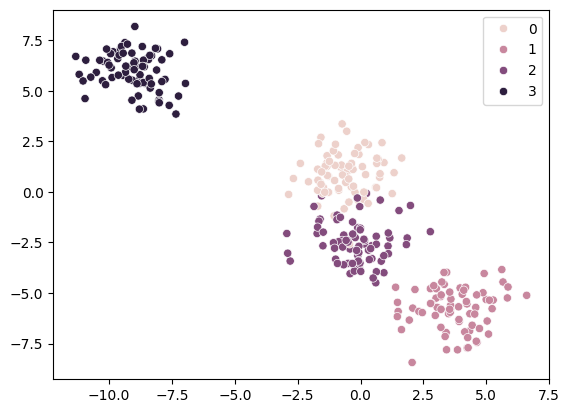

In [ ]:
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y)

In [ ]:
hopkins(X, 300)  # Take all the points

0.17014251536629138

Посмотрим, как оно работает на нормально распределенных данных:

In [ ]:
X_rand, y_rand = datasets.make_blobs(n_samples=300, n_features=20, centers=1)
X_rand.shape

(300, 20)

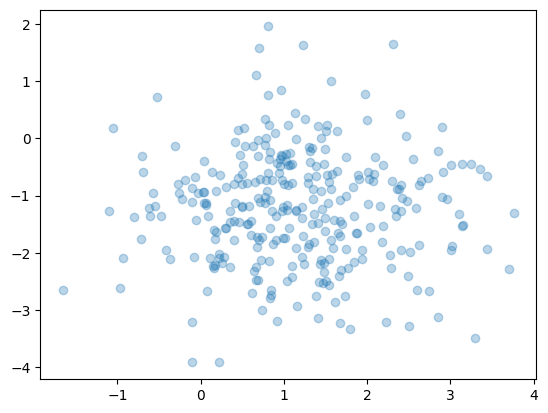

In [ ]:
plt.scatter(X_rand[:,0], X_rand[:,1], alpha=0.3)

In [ ]:
hopkins(X_rand, 300)

0.38786241666455756

#### Визуальный анализ (VAT)

Мы также можем визуально проверить то, насколько структурированы данные в датасете. Для этого мы можем посчитать матрицу сходства между объектами и отсортировать ее.

Подробнее можно почитать [здесь](https://www.datanovia.com/en/lessons/assessing-clustering-tendency/#visual-methods) и в [документации PyClusterTend](https://pyclustertend.readthedocs.io/).

In [ ]:
from pyclustertend import vat

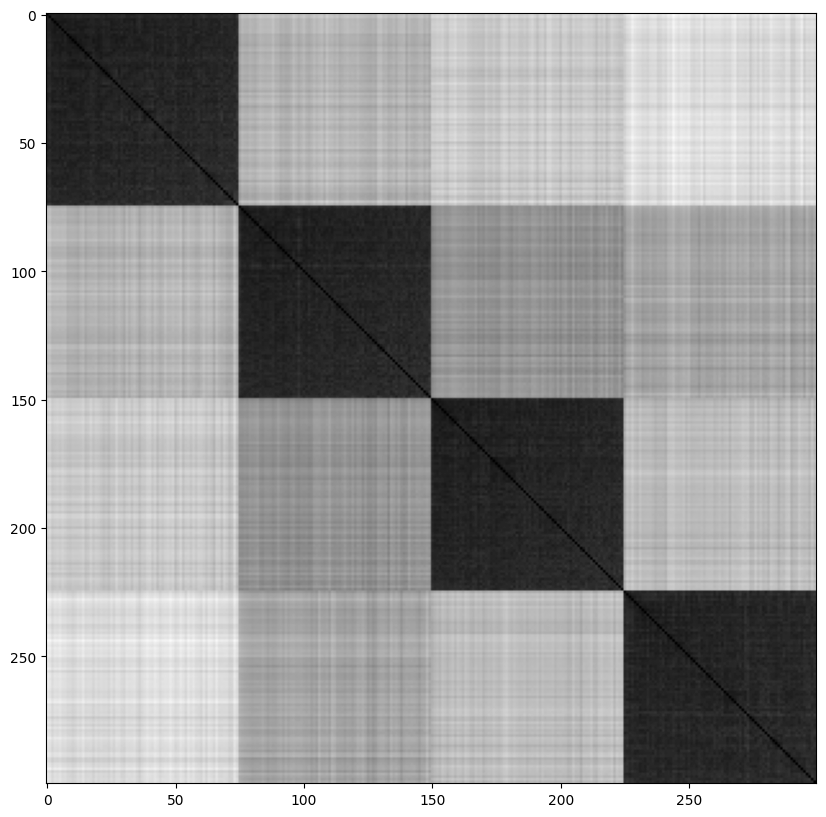

In [ ]:
vat(X)

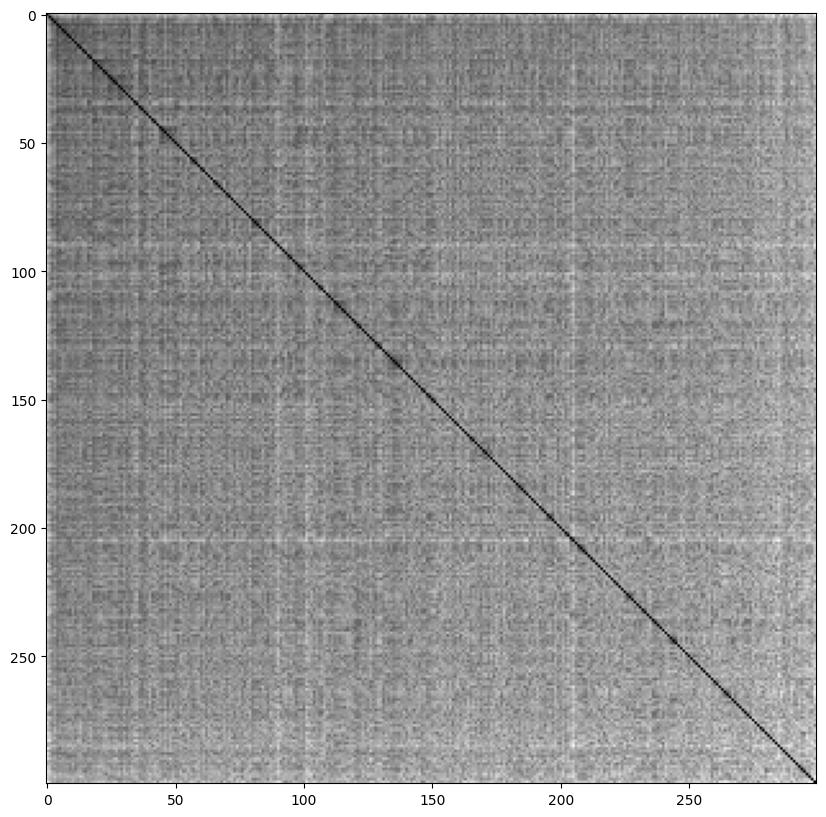

In [ ]:
vat(X_rand)

#### Коэффициент силуэта

Коэффициент силуэта для объекта определяется следующим образом:
* $a$ — среднее расстояние от данного объекта до других объектов из того же кластера;
* $b$ — среднее расстояние от данного объекта до объектов из ближайшего другого кластера.

Считаем коэффициент по формуле:
$$S = \frac{b - a}{max(a, b)}; \quad S \in [-1, 1]$$

Можно посчитать среднее значение коэффициента силуэта по всей выборке, а также распределения по кластерам, посмотреть, есть ли кластеры, у которых среднее значение силуэта ниже среднего по выборке. Если есть, то сменить число кластеров/метод кластеризации.

**Высокие значения $\bar{S}$ соответствуют лучшей кластеризации**.

Сделаем датасет с двумя кластерами средствами `scikit-learn`:

In [ ]:
X_blobs, z_blobs = datasets.make_blobs(n_samples=300, n_features=2, centers=[(1, 0), (-1, 0)], random_state=8)
x_blobs, y_blobs = X_blobs[:,0], X_blobs[:,1]

In [ ]:
z_blobs[:5]

array([1, 1, 1, 0, 1])

<Axes: >

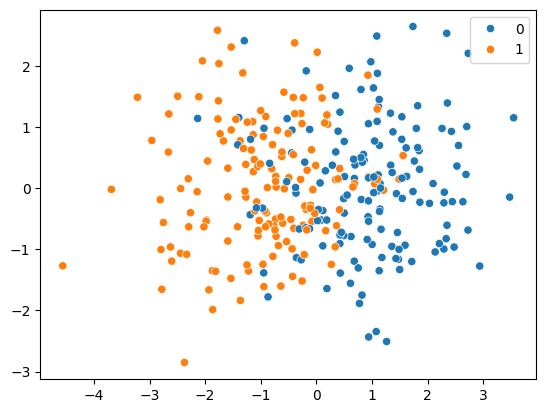

In [ ]:
sns.scatterplot(x=x_blobs, y=y_blobs, hue=z_blobs)

Проверим, насколько хорошо известные метки кластеров описывают данные

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
silhouette_score(X_blobs, z_blobs)

0.22404288665585056

Сравним со случайным разбиением:

In [ ]:
z_blobs_random = np.random.binomial(n=1, p=0.5, size=z_blobs.shape)

<Axes: >

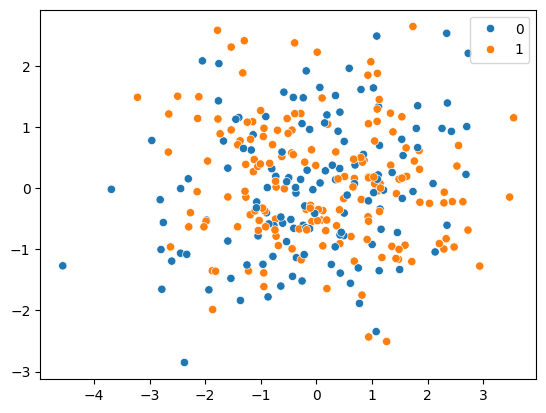

In [ ]:
sns.scatterplot(x=x_blobs, y=y_blobs, hue=z_blobs_random)

In [ ]:
silhouette_score(X_blobs, z_blobs_random)

0.0019802217594672776

Сделаем разбиение визуально:

In [ ]:
z_blobs_visual = x_blobs > 0

<Axes: >

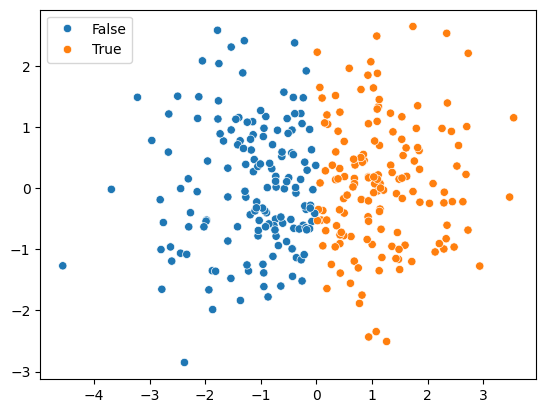

In [ ]:
sns.scatterplot(x=x_blobs, y=y_blobs, hue=z_blobs_visual)

In [ ]:
silhouette_score(X_blobs, z_blobs_visual)

0.3812690964048288

Вычислим значение $S$ для всевозможных разбиений по X:

In [ ]:
margins = np.linspace(x_blobs.min(), x_blobs.max(), 300, endpoint=False)
margins[:10]

array([-4.55945966, -4.53244451, -4.50542935, -4.4784142 , -4.45139904,
       -4.42438388, -4.39736873, -4.37035357, -4.34333841, -4.31632326])

In [ ]:
sil_values = [silhouette_score(X_blobs, x_blobs > x_margin) for x_margin in margins]

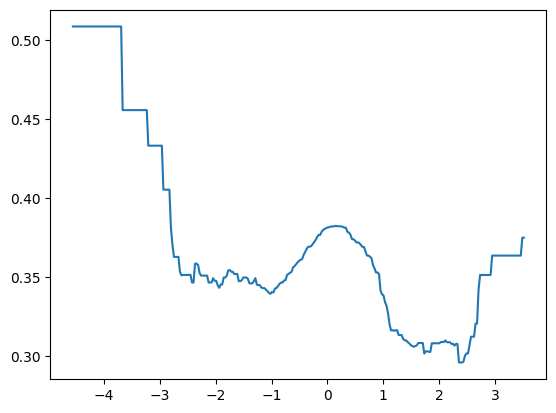

In [ ]:
plt.plot(margins, sil_values)

Максимизируя некую метрику в задаче кластеризации, всегда смотрите на результат!

#### Критерий отношения дисперсий (Calinski -- Harabasz Index)

Общая дисперсия в данных может быть разложена на дисперсию внутри найденных нами кластеров и дисперсию между кластерами. Мы можем посчитать отношение дисперсий:

$$CH_k = \dfrac{SS_{between}}{SS_{within}} \cdot \dfrac{N-k}{k-1}$$

Большие значение Calinski -- Harabasz Index соответствуют более высокому качеству кластеризации.

In [ ]:
from sklearn.metrics import calinski_harabasz_score

In [ ]:
calinski_harabasz_score(X_blobs, z_blobs)

119.7640450461421

In [ ]:
calinski_harabasz_score(X_blobs, z_blobs_random)

1.3282305643774928

In [ ]:
calinski_harabasz_score(X_blobs, z_blobs_visual)

233.88093980328583

In [ ]:
cp_values = [calinski_harabasz_score(X_blobs, x_blobs > x_margin) for x_margin in margins]

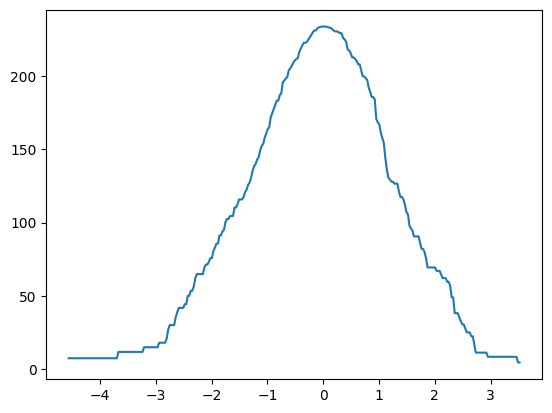

In [ ]:
plt.plot(margins, cp_values)

#### Индекс Рэнда

Зная настоящую разметку классов и результат кластеризации, можно сравнить сходство двух разметок с учетом возможных перестановок идентификаторов групп.

In [ ]:
pd.crosstab(z_blobs, z_blobs_visual.astype("int8"), rownames=["real"], colnames=["visual"])

visual,0,1
real,,
0,27,123
1,126,24


In [ ]:
from sklearn.metrics import adjusted_rand_score

In [ ]:
adjusted_rand_score(z_blobs, z_blobs_visual)

0.4337068003935565

In [ ]:
pd.crosstab(z_blobs, z_blobs_random, rownames=["real"], colnames=["random"])

random,0,1
real,,
0,63,87
1,72,78


In [ ]:
adjusted_rand_score(z_blobs, z_blobs_random)

0.00028992315694104223

Обратите внимание, что эта метрика ничего не знает о самих данных, а только **сравнивает конечные разметки между собой**.

## Алгоритмы кластеризации

Методы кластеризации можно разделить на три группы:
* В которых число кластеров должно быть известно заранее;
* В которых число кластеров находится автоматически в ходе работы алгоритма (при учёте остальных гиперпараметров);
* Иерархическая кластеризация

### k-Means

Задано число кластеров - $k$. Случайно выбираем $k$ точек (не обязательно объектов) - центры кластеров. Каждой остальной точке приписываем номер кластера в зависимости от того, к какому центру она ближе. Пересчитываем центры кластеров как среднее по объектам кластера. Заново приписываем номера точкам. Итерируемся, пока не сошлось.

По сути, итеративно минимизируется среднее внутрикластерное расстояние до центра кластера:

$$F = \sum_{y \in Y}{\frac{1}{\lvert K_y \rvert}}\sum_{i: y_i = y}{\rho^2(\mathbf{x}_i, \mathbf{\mu_y})} \to min$$
$\mathbf{\mu_y}$ - центр кластера $y$.

<table>
<tr>
<td><img src="https://data.bioml.ru/htdocs/courses/bioml/classic_ml/unsupervised/clustering/img/kmeans_ex1.png"/></td>
<td><img src="https://data.bioml.ru/htdocs/courses/bioml/classic_ml/unsupervised/clustering/img/kmeans_ex2.png"/></td>
<!--</tr><tr>-->
<td><img src="https://data.bioml.ru/htdocs/courses/bioml/classic_ml/unsupervised/clustering/img/kmeans_ex3.png"/></td>
<td><img src="https://data.bioml.ru/htdocs/courses/bioml/classic_ml/unsupervised/clustering/img/kmeans_ex4.png"/></td>
</tr>
</table>

![kmeans](https://data.bioml.ru/htdocs/courses/bioml/classic_ml/unsupervised/clustering/img/kmeans_convergence_small.gif)

Попробуем запустить K-Means на сгенерированных данных:

In [ ]:
from sklearn import datasets

X_blobs, z_blobs = datasets.make_blobs(n_samples=300, n_features=2, centers=[(1, 0), (-1, 0)], cluster_std=0.5, random_state=8)
x_blobs, y_blobs = X_blobs[:,0], X_blobs[:,1]

<Axes: >

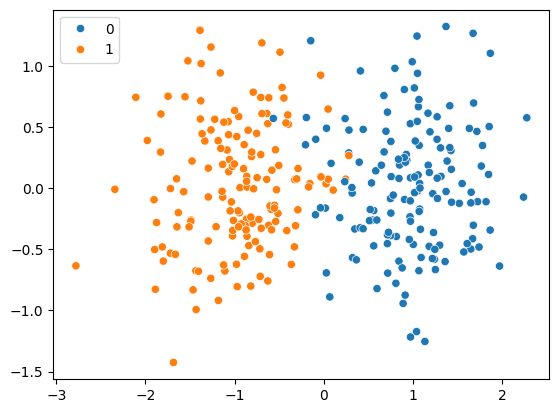

In [ ]:
sns.scatterplot(x=x_blobs, y=y_blobs, hue=z_blobs)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)
z_blobs_kmeans = kmeans.fit_predict(X_blobs)

<Axes: >

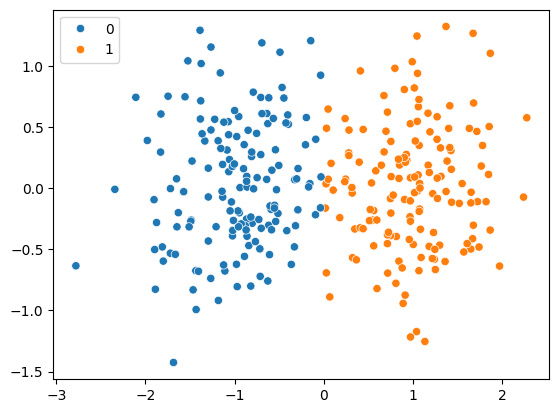

In [ ]:
sns.scatterplot(x=x_blobs, y=y_blobs, hue=z_blobs_kmeans)

А что будет, если выставить неверное число кластеров?

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=105)
z_blobs_kmeans = kmeans.fit_predict(X_blobs)

<Axes: >

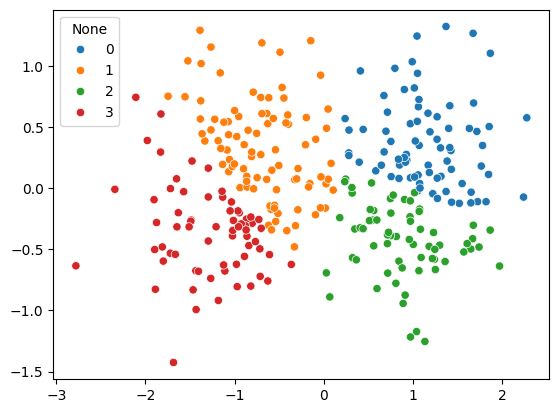

In [ ]:
sns.scatterplot(x=x_blobs, y=y_blobs, hue=pd.Series(z_blobs_kmeans, dtype="category"))

А что если кластеры имеют необычную форму?

<Axes: >

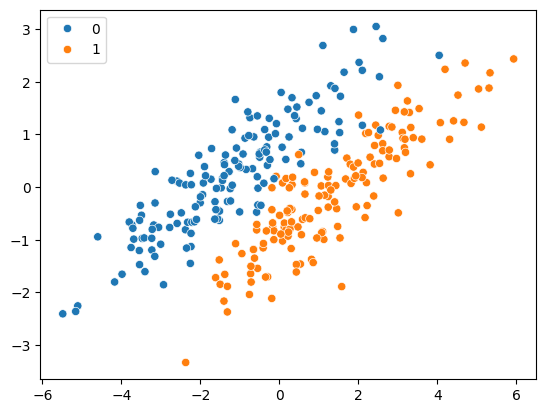

In [ ]:
transform = np.array([[-1.3, 0.2],
                      [ 3.2, 2.1]])
X_sh = X_blobs @ transform
x_sh, y_sh = X_sh[:,0], X_sh[:,1]
z_sh = z_blobs

sns.scatterplot(x=x_sh, y=y_sh, hue=z_sh)

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)
z_sh_kmeans = kmeans.fit_predict(X_sh)

<Axes: >

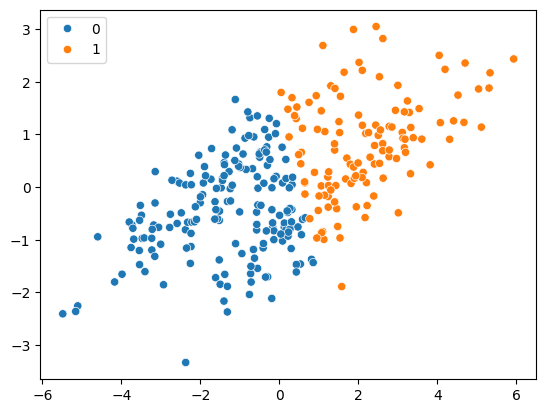

In [ ]:
sns.scatterplot(x=x_sh, y=y_sh, hue=z_sh_kmeans)

Можно все испортить еще более простым образом

<Axes: >

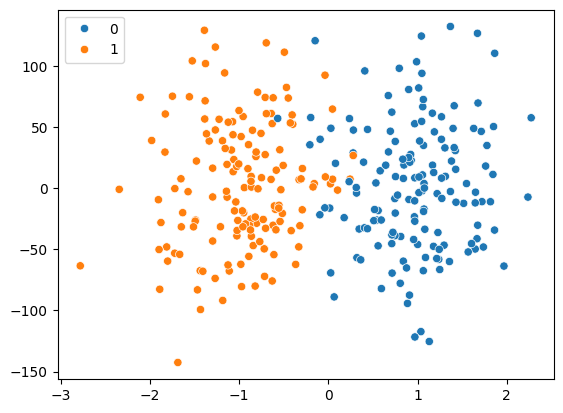

In [ ]:
X_stretched = X_blobs * np.array([1, 100])
x_stretched, y_stretched = X_stretched[:,0], X_stretched[:,1]
z_stretched = z_blobs
sns.scatterplot(x=x_stretched, y=y_stretched, hue=z_stretched)

<Axes: >

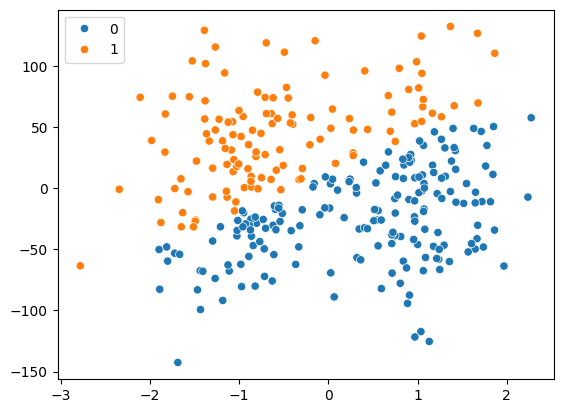

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)
z_stretched_kmeans = kmeans.fit_predict(X_sh)
sns.scatterplot(x=x_stretched, y=y_stretched, hue=z_stretched_kmeans)

Перед кластеризацией данные с разными масштабами осей **нужно нормализовать**!

Еще один тест:

<Axes: >

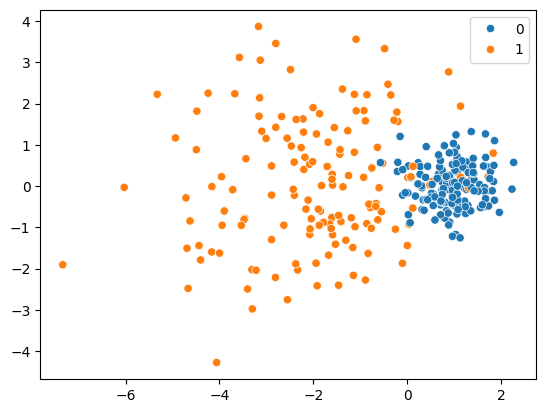

In [ ]:
X_uv, z_uv = datasets.make_blobs(n_samples=300, n_features=2, centers=[(1, 0), (-2, 0)], cluster_std=[0.5, 1.5], random_state=8)
x_uv, y_uv = X_uv[:,0], X_uv[:,1]
sns.scatterplot(x=x_uv, y=y_uv, hue=z_uv)

<Axes: >

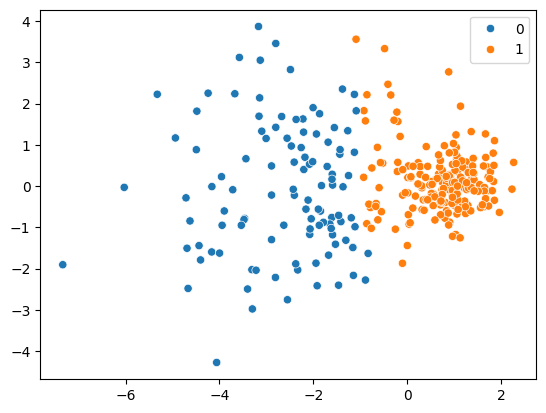

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)
z_uv_kmeans = kmeans.fit_predict(X_uv)
sns.scatterplot(x=x_uv, y=y_uv, hue=z_uv_kmeans)

#### Подвиды K-Means

Если на центры накладывается условие, что это обязательно объекты выборки, тогда алгоритм называется **K-Medoids**.

**K-means++** - метод с более хитрой инициализацией.

В качестве первого центра берется случайный объект из выборки.

Далее объекты взвешиваются так, что вероятность выбрать точку следующим центром пропорциональна квадрату расстояния от этой точки до ближайшего центра. Таким образом мы получаем более далекие друг от друга центры кластеров.

Не самая плохая идея использовать k-Means, если нам надо "огрублять" наши признаки - каких-то категорий слишком много, а мы хотим уменьшить их число (например, количество цветов изображения). Тогда скластеризуем исходные значения и в качестве нового признака будем использовать метку кластера.

### DBSCAN

В одной из реализаций звучит примерно так:
* Точка считается основной, если в её окрестности $\rho$ есть более $k$ точек.
* Точка считается граничной, если в её окрестности есть основные точки, но суммарно соседних точек меньше $k$. (иногда граничные не рассматриваются)
* Точка считается шумовой, если в её окрестности меньше $k$ точек, среди них нет основных.
* Отнесём все точки выборки к одному из трёх классов. Каждая группа основных точек (с прилегающими к ним граничными) - кластер. Шумовые точки не относятся ни к какому кластеру (*отказ от кластеризации*).

![dbscan_smiley.gif](https://data.bioml.ru/htdocs/courses/bioml/classic_ml/unsupervised/clustering/img/dbscan_smiley.gif)

Создадим игрушечный датасет:

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
X, z_true = datasets.make_blobs(n_samples=250,
                                centers=[[1, 1], [-1, -1], [1, -1]],
                                cluster_std=0.4,
                                random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

<Axes: >

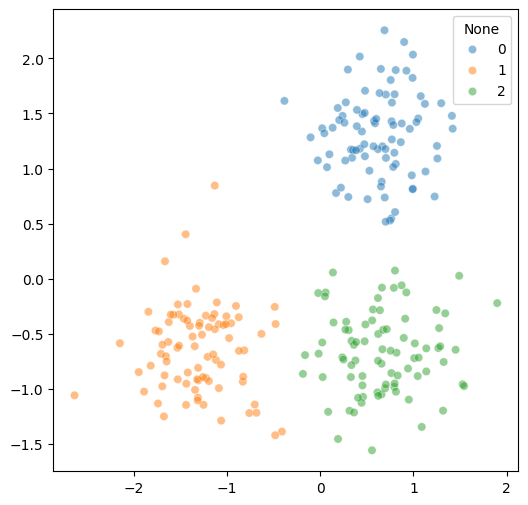

In [ ]:
x, y = X_scaled[:,0], X_scaled[:,1]

plt.figure(figsize=(6, 6))
sns.scatterplot(x=x, y=y, hue=pd.Series(z_true, dtype="category"), alpha=0.5)

In [ ]:
def plot_dbscan(X, dbscan_model, fit=False):
    if fit:
        dbscan_model.fit(X)

    core_samples_mask = np.zeros_like(dbscan_model.labels_, dtype=bool)
    core_samples_mask[dbscan_model.core_sample_indices_] = True
    labels = dbscan_model.labels_
    n_clusters_ = len(set(labels) - {-1})

    unique_labels = set(labels)
    plt.figure(figsize=(8, 8))
    for i, cluster in enumerate(unique_labels):
        color = "k" if cluster == -1 else f"C{i}"
        edgecolor = "k" if cluster == -1 else "w"

        class_member_mask = (labels == cluster)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], "o", markerfacecolor=color,
                markeredgecolor=edgecolor, markersize=14, alpha=0.5)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], "o", markerfacecolor=color,
                markeredgecolor=edgecolor, markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
dbscan = DBSCAN(eps=0.3, min_samples=10)
dbscan.fit(X_scaled)

DBSCAN(eps=0.3, min_samples=10)

In [ ]:
n_clusters_ = len(set(dbscan.labels_) - {-1})
n_noise_ = np.count_nonzero(dbscan.labels_ == -1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 3
Estimated number of noise points: 41


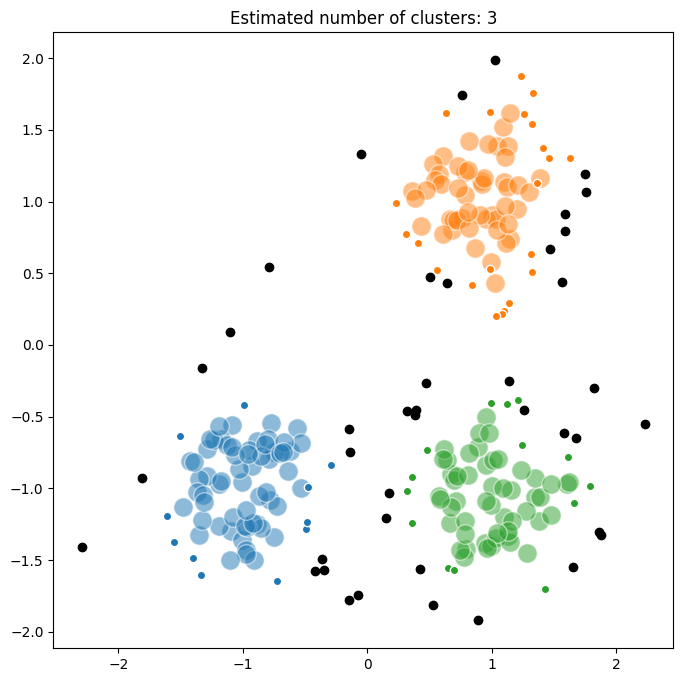

In [ ]:
plot_dbscan(X, dbscan)

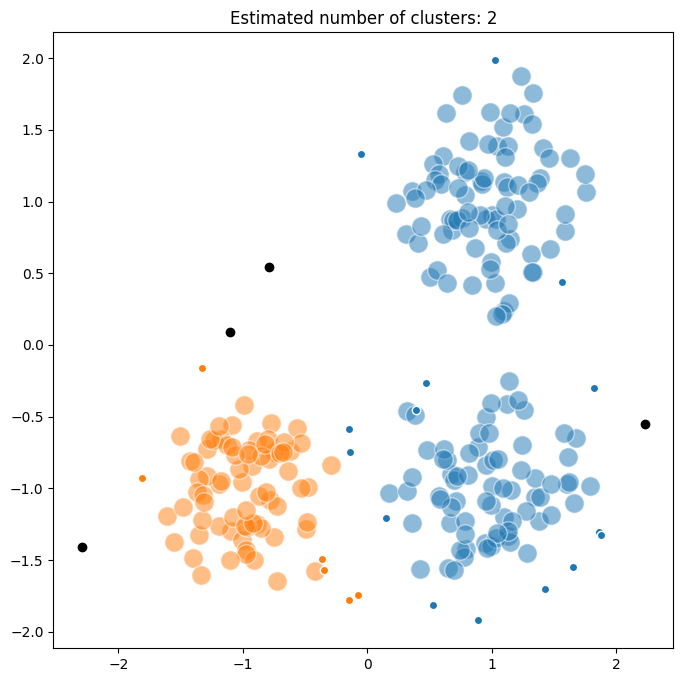

In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan.fit(X_scaled)
plot_dbscan(X, dbscan)

### Иерархическая кластеризация

Есть два подхода к иерархической кластеризации:

* **Top-down** (division) - объединить все объекты в один кластер, после чего его последовательно разбивать на подкластеры.
* **Bottom-up** (agglomerative) - вначале каждый объект - отдельный кластер, после чего их последовательно соединять.

Как правило применяют методы из второй группы, разберём шаги поподробнее:

1. Посчитать попарную матрицу расстояний между объектами;
2. Присвоить каждому объекту свой кластер;
3. Слить кластеры, которые находятся друг с другом на наименьшем расстоянии;
4. Пересчитать расстояния от получившегося кластера до всех остальных;
5. Повторять шаги 3-4, пока не останется один кластер.

![wheat](https://data.bioml.ru/htdocs/courses/bioml/classic_ml/unsupervised/clustering/img/hierarchical_wheat.png)

Способы подсчёта расстояний между объектами:

* Nearest point algorithm (единичная связь) $$d(u,v) = \min(dist(u[i],v[j]))$$

* Farthest Point Algorithm (полная связь) $$d(u, v) = \max(dist(u[i],v[j]))$$

* UPGMA (невзвешенная средняя связь) $$d(u,v) = \sum_{ij} \frac{d(u[i], v[j])}{(|u|*|v|)}$$

* WPGMA (взвешенная средняя связь) $$d(u,v) = (dist(s,v) + dist(t,v))/2$$

* UPGMC (центроидный метод) $$d(u,v) = ||c_u-c_v||_2$$

* Ward distance (учёт прироста дисперсии) $$d(u,v) = \sqrt{\frac{|v|+|s|}{T}d(v,s)^2 + \frac{|v|+|t|}{T}d(v,t)^2 + \frac{|v|}{T}d(s,t)^2}$$

где $u$ - вновь присоединенный кластер, состоящий из кластеров $s$ и $t$, $v$ - неиспользуемый кластер,  $T = | v | + | s | + | t |$. Прирост суммы квадратов расстояний объектов до центра кластера должен быть минимальным при объединении кластеров.

### Другие алгоритмы

Сравнение кучи алгоритмов на игрушечных данных:

![toy_clustering](https://data.bioml.ru/htdocs/courses/bioml/classic_ml/unsupervised/clustering/img/clustering_cluster_comparison_sklearn_001.png)

Можете почитать про наиболее заинтересовавшие Вас самостоятельно.

## Правила работы с алгоритмами кластеризации

* Критически воспринимайте результат алгоритма! (Это верно не только про кластеризацию.) Кластеризация часто может являться субъективным подгоном под желаемое.
* Кластеризация лучше всего валидируется на данных, где есть GT-разметка. Считаем и оптимизируем разные метрики качества.
* Рекомендуется кластеризовать данные несколько раз с разными инициализациями генератора псевдослучайных чисел, добавлять к данным шум и смотреть на устойчивость структуры кластеров.

## Примеры из биологии

### Филогенетическая реконструкция

Задача филогенетической реконструкции заключается в построении связного ациклического графа, отражающего эволюционные связи между биологическими объектами, например, белковыми доменами, генами или видами организмов. Для такого построения может использоваться различная информация о данных объектах, например, белковые последовательности доменов, последовательности ДНК генов, морфологические признаки видов либо их полные геномы и многое другое.

Полученный граф называется дендрограммой, а также филогенетическим, или эволюционным, деревом.

В структуре филогенетического дерева могут встречаться следующие элементы:
* узел – внутренняя вершина графа, представляющая собой точку разделения предкового биологического объекта на двух независимо эволюционирующих потомков;
* лист – внешняя вершина графа, соответствующая современному рассматриваемому биологическому объекту;
* ветвь – ребро графа, обозначающая связь между гипотетически существующими или реальными объектами;
* корень – ближайший общий предок (MRCA) всех представленных в дереве биологических объектов;
* клада – группа объектов, включающая некоторого предка и всех его потомков.  


Подробнее обсудим на семинаре.

### Анализ данных экспрессии

Кластеризация производится перед анализом дифференциальной экспрессии в качестве quality check (убедиться, что данные действительно приходят из нескольких отличающихся групп).

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/clustering/heatmap.png" alt="Drawing" width= "600px;"/>

### Опухолевые портреты

Работа по кластеризации опухолей на основе их микроокружения и свойств злокачественных клеток.

Было подготовлено 29 функциональных сигнатур генной экспрессии, связанных с основными клеточными процессами опухоли (скорость пролиферации и сигнатура эпителиально-мезенхимального перехода) и её микроокружения (разные типы иммунного инфильтрата, фиброз, ангиогенез и пр.).

На основе ssGSEA-скоров (single-sample geneset enrichment analysis) этих сигнатур была произведена кластеризация образцов кожной меланомы <a href='https://arxiv.org/pdf/1410.1237.pdf'>методом Лувена</a>.

Получилось выделить 4 подтипа опухолей (т.н. "портретов") в зависимости от микроокружения. Портреты хорошо коррелируют с выживаемостью и ответом на иммунотерапию.

Более того, эти подтипы оказались устойчивыми в разных диагнозах, что было провалидировано на датасете, составленном из множества датасетов различных карцином и меланом.

Source: https://doi.org/10.1016/j.ccell.2021.04.014

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/clustering/portraits.png" alt="Drawing" width= "1000px;"/>